In [1]:
from functools import partial
from collections import ChainMap
from typing import TypedDict

import numpy as np
import matplotlib.pyplot as plt
import trimesh
from trimesh import Scene

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from problem import mesh, get_transformed_scene, raytrace_silhouette, stochastic_jacaard_index
from spsa import OptimSPSA, SPSA_Params

c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


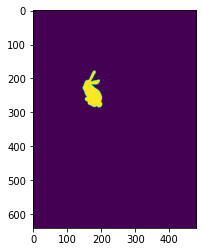

In [2]:
true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, perc=1)

plt.imshow(true_sil == 2)

0.4997522299306244


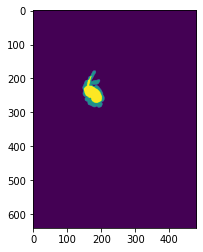

In [3]:

rotation = true_rotation + np.array([.6, .1, .2])
translation = true_translation # + np.array([-.5, -.5, -4])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, perc=1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow(sil + true_sil)

0.03575355994979634

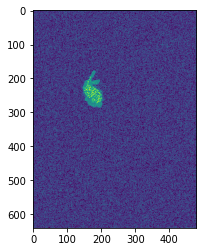

In [4]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = theta
    translation = true_translation
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_sil(sil):
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

def get_loss_from_theta(theta: np.ndarray, perc=0.5, v=None):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc, inds=v)
    return get_loss_from_sil(sil)

def v_generator(perc=0.5):
    return np.random.choice(640 * 480, int(640 * 480 * perc), False)

theta_0 = np.array(rotation)

scene = get_scene_from_theta(theta_0)
sil = raytrace_silhouette(scene, perc=0.5)
plt.imshow(sil + true_sil)

get_loss_from_theta(theta_0)


In [5]:
fig, ax = plt.subplots()

theta = np.array(theta_0)
optim = OptimSPSA(np.array(theta), get_loss_from_theta, max_delta_theta=0.1, max_iter=200)
optim.calibrate(True)

scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)

img = ax.imshow(sil + true_sil)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    theta = optim.step()
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=1)
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_sil(sil)}")
    
    img.set_data(sil + true_sil)
    return img

ani = FuncAnimation(fig, update, frames=range(50), blit=False, interval=100)
HTML(ani.to_jshtml())

After calibration:  {'gamma': 0.101, 'alpha': 0.602, 't0': 0.5, 'num_approx': 1, 'max_delta_theta': 0.1, 'max_iter': 200, 'A': 26.0, 'c0': 0.04192208775939504, 'a0': 0.37857254174818783}
0: -0.05318023173504294
0: -0.04957210145880908
10: -1.857534848903023
20: -2.2211447610538717
30: -2.6541218590766533
40: -1.9927372428440089


In [22]:
fig, ax = plt.subplots()

theta = np.array(theta_0)
optim = OptimSPSA(np.array(theta), get_loss_from_theta, v_generator, max_delta_theta=0.1, max_iter=200)
optim.calibrate(True)

scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)

img = ax.imshow(sil + true_sil)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    theta = optim.step()
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=1)
    if i % 20 == 0:
        print(f"{i}: {get_loss_from_sil(sil)}")
    
    img.set_data(sil + true_sil)
    return img

ani = FuncAnimation(fig, update, frames=range(200), blit=False, interval=100)
HTML(ani.to_jshtml())

After calibration:  {'gamma': 0.101, 'alpha': 0.602, 't0': 0.5, 'num_approx': 1, 'max_delta_theta': 0.1, 'max_iter': 200, 'A': 26.0, 'c0': 0.06458089082474423, 'a0': 0.5059434970844336}
0: 1.8084000326995835
0: 1.764829357182819
20: 1.1182636777472104
40: 0.7533219035960153
60: 0.41511057295886955
80: 0.350664833428304
100: 0.15703126294505354
120: 0.0023598831010909205
140: -0.017730445584223764
160: -0.27560949121751166
180: -0.48050993410124543


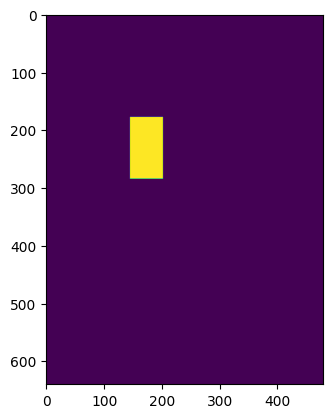

In [45]:
def bounding_box(mask):
    # Get the x and y coordinates of non-zero values in the mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def combine_bounding_boxes(bb1, bb2):
    return min(bb1[0], bb2[0]), max(bb1[1], bb2[1]), min(bb1[2], bb2[2]), max(bb1[3], bb2[3])

def bbox_to_mask(bbox, shape):
    rmin, rmax, cmin, cmax = bbox
    arr = np.zeros(shape)
    arr[rmin:rmax, cmin:cmax] = 1
    return arr

def get_scale(bb):
    return bb[1] - bb[0] + bb[3] - bb[2]

bounding_box(sil == 2)

bounding_box(true_sil == 2)
plt.imshow(bbox_to_mask(bounding_box(true_sil == 2), true_sil.shape))

In [43]:
get_scale(bounding_box(sil))

1118

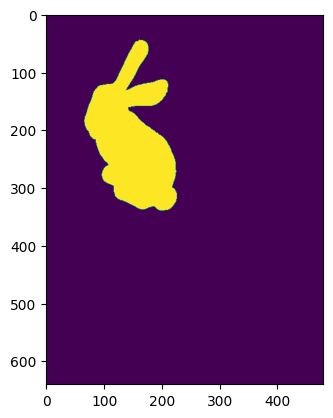

In [32]:
plt.imshow(sil)

In [37]:
%%timeit
bounding_box(sil == 2)

65.1 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Given a Z, I can find the transformation matrix that translates it

I can also determine the scale... 
